# Aprendizaje de Máquina - Tarea 1
## Predicción del precio de venta

Formular un modelo que prediga los precios de venta de casas usando tecnicas de aprendizaje de máquina. 

La situación problema y datos son tomados de: 
- [House Price - Kaggle](!https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview)

Librerias necesarias para la lectura y manejo de los datos.
- pandas : encargada de construir, leer y manipular el conjunto de datos.
- numpy : se encarga del casteo de tipos, es decir convertir todo a float64.
- mathplotlib : permite generar gráficas a partir de un conjunto de datos. 
- scipy : libreria de herramientas estadisticas. 
- sklearn : libreria de herramientas para aprendizaje. 

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import wilcoxon
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

### Lectura de datos y selección de variables.

En un primer paso, se realiza la lectura de los datos de entrenamiento. Para ello, junto al notebook se debe ubicar el archivo *train.csv*

In [21]:
trainFile = 'train.csv'
trainDataOrg = pd.read_csv(trainFile)
trainDataOrg

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


De acuerdo a la descripción de los datos que proporciona Kaggle hay 80 variables a considerar. Sin embargo, se han tomado un pequeño grupo de ellas para predecir los precios de venta. Algunas son: 

- YearBuilt : año de construcción.
- YearRemodAdd : año de remodelación.
- OverallCond : estado general de la casa. 
- OverallQual : calidad general de la casa. 
- ExterCond : estado de la fachada, *cualitativa*.
- KitchenQual : estado de la cocina, *cualitativa*.

es posible agrupar algunas de ellas en una sola variable, por ejemplo las variables: 
- TotalBsmtSF 
- 1stFlrSF 
- 2ndFlrSF 
- GarageArea 
- WoodDeckSF
- ScreenPorch 
- PoolArea 
- 3SsnPorch 
- EnclosedPorch 
- OpenPorchSF 
- WoodDeckSF

todas hablan sobre área construida y se pueden sumar para obtener una nueva variable AreaTot.

Algunas de las variables son de tipo cualitativas y por lo tanto es neceseario convertirlas a escalas numéricas.


In [22]:
conversion = {'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4}

Se filtra y construye un nuevo conjunto de datos con las variables seleccionadas. Observe que se hace un casteo(conversión de datos) a float64, sin esta operación se generar errores de tipos.

In [23]:


trainData = pd.DataFrame(data={'YearBuilt': trainDataOrg.YearBuilt,
                               'YearRemodAdd': trainDataOrg.YearRemodAdd,
                               'OverallCond': trainDataOrg.OverallCond,
                               'ExterCond': trainDataOrg.ExterCond,
                               'TotalArea': trainDataOrg.LotArea + trainDataOrg.TotalBsmtSF 
                                    + trainDataOrg['1stFlrSF'] + trainDataOrg['2ndFlrSF'] 
                                    + trainDataOrg.GarageArea + trainDataOrg.WoodDeckSF
                                    + trainDataOrg.ScreenPorch + trainDataOrg.PoolArea 
                                    + trainDataOrg['3SsnPorch'] + trainDataOrg.EnclosedPorch 
                                    + trainDataOrg.OpenPorchSF + trainDataOrg.WoodDeckSF,
                                'KitchenQual': trainDataOrg.KitchenQual,
                                'OverallQual': trainDataOrg.OverallQual })

trainData['ExterCond'].replace(conversion,inplace=True)
trainData['KitchenQual'].replace(conversion,inplace=True)

for col in trainData: 
    trainData[col] = trainData[col].fillna(0).astype(np.float64)


trainData

,YearBuilt,YearRemodAdd,OverallCond,ExterCond,TotalArea,KitchenQual,OverallQual
0,2003.0,2003.0,5.0,2.0,11625.0,3.0,7.0
1,1976.0,1976.0,8.0,2.0,13180.0,2.0,6.0
2,2001.0,2002.0,5.0,2.0,14606.0,3.0,7.0
3,1915.0,1970.0,5.0,2.0,12972.0,3.0,7.0
4,2000.0,2000.0,5.0,2.0,18907.0,3.0,8.0
...,...,...,...,...,...,...,...
1455,1999.0,2000.0,5.0,2.0,11017.0,2.0,6.0
1456,1978.0,1988.0,6.0,2.0,17988.0,2.0,6.0
1457,1941.0,2006.0,9.0,3.0,12846.0,3.0,7.0
1458,1950.0,1996.0,6.0,2.0,12957.0,3.0,5.0


### Selección estadística de las variables.
Se procede a graficar los datos para determinar si siguen alguna distribución.

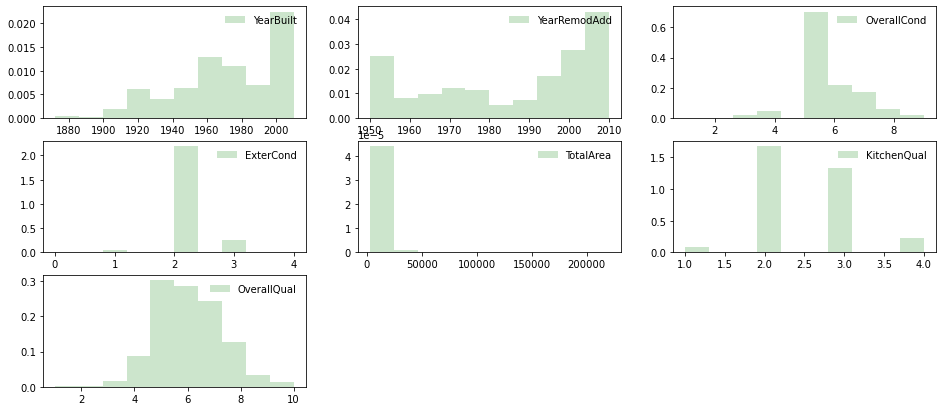

In [24]:
fig, ax = plt.subplots(3, 3, figsize=(16,7))
fig.delaxes(ax[2][1])
fig.delaxes(ax[2][2])
t = 0
for col in trainData:
    i = int(t/3)
    j = t%3
    ax[i][j].hist(trainData[col], density=True, histtype='stepfilled', alpha=0.2,label=col,color = "green")
    ax[i][j].legend(loc='best', frameon=False)
    t+=1
# ax[i][j].set(xlabel='Value', ylabel='Probability')

En las gráficas se puede observar que ninguna variable sigue una distribución normal. Ahora se gráfica la distribución que siguen los precios.

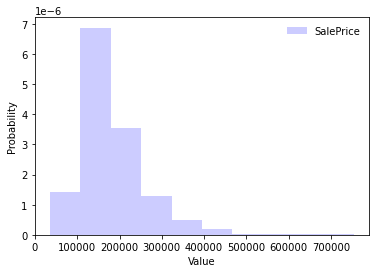

In [25]:
fig, ax = plt.subplots(1,1)
ax.hist(trainDataOrg.SalePrice, density=True, histtype='stepfilled', alpha=0.2,label='SalePrice',color = "blue")
ax.set(xlabel='Value', ylabel='Probability')
ax.legend(loc='best', frameon=False)
plt.show()

De acuerdo a las gráficas anteriores, se considera entonces que los datos no siguen una distribución normal. Por lo que para el cálculo de la matriz de correlación se una un test de [Spearman](!https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient).

In [26]:
correlationMatrix = trainData.corr(method='spearman')
correlationMatrix

,YearBuilt,YearRemodAdd,OverallCond,ExterCond,TotalArea,KitchenQual,OverallQual
YearBuilt,1.000000,0.684388,-0.416964,-0.116672,0.195541,0.597696,0.647392
YearRemodAdd,0.684388,1.000000,-0.041464,0.043496,0.152626,0.659769,0.557723
OverallCond,-0.416964,-0.041464,1.000000,0.329091,-0.082349,-0.089707,-0.177521
ExterCond,-0.116672,0.043496,0.329091,1.000000,0.032002,0.046113,-0.015870
TotalArea,0.195541,0.152626,-0.082349,0.032002,1.000000,0.259867,0.349700
KitchenQual,0.597696,0.659769,-0.089707,0.046113,0.259867,1.000000,0.660498
OverallQual,0.647392,0.557723,-0.177521,-0.015870,0.349700,0.660498,1.000000


Se observa que existe una correlación fuerte entre algunas de las variables, sin embargo no es lo [suficientemente](!https://www.statstutor.ac.uk/resources/uploaded/spearmans.pdf) fuerte para quedarse solo con una de ellas. 

Por otro lado, dado que tanto las variables como los precios no siguen una distribución normal, se prefiere un test no paramétrico de Mann-Whitney.

In [35]:
for col in trainData:
    stat, pvalue = wilcoxon(trainData[col],trainDataOrg.SalePrice)
    print('El p-valor entre',col,'y los precios es de',pvalue)

El p-valor entre YearBuilt y los precios es de 3.3428994828814527e-240
El p-valor entre YearRemodAdd y los precios es de 3.342831543018929e-240
El p-valor entre OverallCond y los precios es de 3.3413380960025666e-240
El p-valor entre ExterCond y los precios es de 3.33744397342954e-240
El p-valor entre TotalArea y los precios es de 3.3429568357834503e-240
El p-valor entre KitchenQual y los precios es de 3.339044088218165e-240
El p-valor entre OverallQual y los precios es de 3.3411573043675354e-240


Se observan unos p-valores bastante pequeños, por lo que es posible rechazar la [hipótesis nula](!https://dataschool.com/fundamentals-of-analysis/correlation-and-p-value/), la cual nos dice que no existe relación entre cada una de las variables y el precio de venta.

### Generación del modelo
Para generar un modelo de predicción se ha utilizado Lasso.

In [44]:
lasso_model = Lasso(alpha=0.9,normalize=True, max_iter=1e9)
lasso_model.fit(trainData, trainDataOrg.SalePrice)

Lasso(alpha=0.9, max_iter=1000000000.0, normalize=True)

Se carga y crea el conjunto de datos de prueba.

In [45]:
testFile = 'test.csv'
testDataOrg = pd.read_csv(testFile)

In [46]:
testData = pd.DataFrame(data={ 'YearBuilt': testDataOrg.YearBuilt,
                               'YearRemodAdd': testDataOrg.YearRemodAdd,
                               'OverallCond': testDataOrg.OverallCond,
                               'ExterCond': testDataOrg.ExterCond,
                               'TotalArea': testDataOrg.LotArea + testDataOrg.TotalBsmtSF 
                                    + testDataOrg['1stFlrSF'] + testDataOrg['2ndFlrSF'] 
                                    + testDataOrg.GarageArea + testDataOrg.WoodDeckSF
                                    + testDataOrg.ScreenPorch + testDataOrg.PoolArea 
                                    + testDataOrg['3SsnPorch'] + testDataOrg.EnclosedPorch 
                                    + testDataOrg.OpenPorchSF + testDataOrg.WoodDeckSF,
                               'KitchenQual':testDataOrg.KitchenQual, 
                               'OverallQual': testDataOrg.OverallQual })
testData['ExterCond'].replace(conversion,inplace=True)
testData['KitchenQual'].replace(conversion,inplace=True)

for col in testData: 
    testData[col] = testData[col].fillna(0).astype(np.float64)


testData

,YearBuilt,YearRemodAdd,OverallCond,ExterCond,TotalArea,KitchenQual,OverallQual
0,1961.0,1961.0,6.0,2.0,14530.0,2.0,5.0
1,1958.0,1958.0,6.0,2.0,18059.0,3.0,6.0
2,1997.0,1998.0,5.0,2.0,17327.0,2.0,5.0
3,1998.0,1998.0,6.0,2.0,13734.0,3.0,6.0
4,1992.0,1992.0,5.0,2.0,8297.0,3.0,8.0
...,...,...,...,...,...,...,...
1454,1970.0,1970.0,7.0,2.0,3574.0,2.0,4.0
1455,1970.0,1970.0,5.0,2.0,3842.0,2.0,4.0
1456,1960.0,1996.0,7.0,2.0,23972.0,2.0,5.0
1457,1992.0,1992.0,5.0,2.0,12515.0,2.0,5.0


In [47]:
lasso_model.predict(testData)

array([131157.22331751, 193453.06405278, 143067.97249941, ...,
       148022.74002066, 134161.14302168, 201670.07560547])

Se grafican los resultados.

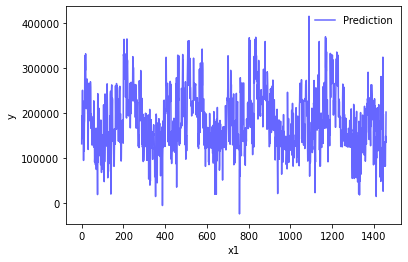

In [48]:
plt.plot(testData.index, lasso_model.predict(testData),'b',alpha=0.6, label='Prediction')
plt.legend(loc='best', frameon=False)
plt.xlabel('x1')
plt.ylabel('y')
plt.show()

### Generación del archivo de salida, prueba con Kaggle
En este apartado se genera el archivo *output.csv* con los valores predecidos para los datos de validación. El objetivo es hacer el *submit* en Kaggle.

In [49]:
outputData = pd.DataFrame(data={'SalePrice':lasso_model.predict(testData)})
outputData.index += 1461
outputData.to_csv("output.csv")
outputData

,SalePrice
1461,131157.223318
1462,193453.064053
1463,143067.972499
1464,195685.142656
1465,250045.511483
...,...
2915,83823.818750
2916,82507.297520
2917,148022.740021
2918,134161.143022


Campo de comentarios varios y programación 


<!--

YearBuilt

YearRemodAdd

OverallCond

OverallQual

ExterCond

KitchenQual

LotArea - TotalBsmtSF - 1stFlrSF - 2ndFlrSF - GarageArea - WoodDeckSF
    : ScreenPorch - PoolArea - 3SsnPorch - EnclosedPorch - OpenPorchSF - WoodDeckSF
    
    
    
    'TotalArea': trainDataOrg.LotArea + trainDataOrg.TotalBsmtSF 
+ trainDataOrg['1stFlrSF'] + trainDataOrg['2ndFlrSF'] 
+ trainDataOrg.GarageArea + trainDataOrg.WoodDeckSF
+ trainDataOrg.ScreenPorch + trainDataOrg.PoolArea 
+ trainDataOrg['3SsnPorch'] + trainDataOrg.EnclosedPorch 
+ trainDataOrg.OpenPorchSF + trainDataOrg.WoodDeckSF



                               'TotalArea': testDataOrg.LotArea + testDataOrg.TotalBsmtSF 
                                    + testDataOrg['1stFlrSF'] + testDataOrg['2ndFlrSF'] 
                                    + testDataOrg.GarageArea + testDataOrg.WoodDeckSF
                                    + testDataOrg.ScreenPorch + testDataOrg.PoolArea 
                                    + testDataOrg['3SsnPorch'] + testDataOrg.EnclosedPorch 
                                    + testDataOrg.OpenPorchSF + testDataOrg.WoodDeckSF



testData['ExterCond'].replace(conversion,inplace=True)
testData['KitchenQual'].replace(conversion,inplace=True)
'ExterCond': testDataOrg.ExterCond,
                               'KitchenQual': testDataOrg.KitchenQual 



'TotalArea': trainDataOrg.LotArea + trainDataOrg.TotalBsmtSF 
                                    + trainDataOrg['1stFlrSF'] + trainDataOrg['2ndFlrSF'] 
                                    + trainDataOrg.GarageArea + trainDataOrg.WoodDeckSF
                                    + trainDataOrg.ScreenPorch + trainDataOrg.PoolArea 
                                    + trainDataOrg['3SsnPorch'] + trainDataOrg.EnclosedPorch 
                                    + trainDataOrg.OpenPorchSF + trainDataOrg.WoodDeckSF
 














'TotalArea': testDataOrg.LotArea + testDataOrg.TotalBsmtSF 
                                    + testDataOrg['1stFlrSF'] + testDataOrg['2ndFlrSF'] 
                                    + testDataOrg.GarageArea + testDataOrg.WoodDeckSF
                                    + testDataOrg.ScreenPorch + testDataOrg.PoolArea 
                                    + testDataOrg['3SsnPorch'] + testDataOrg.EnclosedPorch 
                                    + testDataOrg.OpenPorchSF + testDataOrg.WoodDeckSF



-->

